# Artificial Neural Networks and Deep Learning 2022 - Homework 1
### Politecnico di Milano
Team name: bisogna_tenersi_idratati_nelle_ore_più_calde

Team members:
- Alex Amati
- Stefano Civelli
- Luca Molteni

In this notebook we will first train 5 model (4 of them using keras application pretrained models with fine tuning):
-   EfficientNetB3;
-   ConvNextTiny;
-   a custom one;
-   EfficientNetV2B3.

Then we will ensamble the first three concatenating their features and then feeding this latent rapresentation into a dense classifier (we called this model Zusammenlegen).

And at the end we will specify a class to perform a majority vote between *ConvNextTiny*, *EfficientNetV2B3* and the so called *Zusammenlegen*.

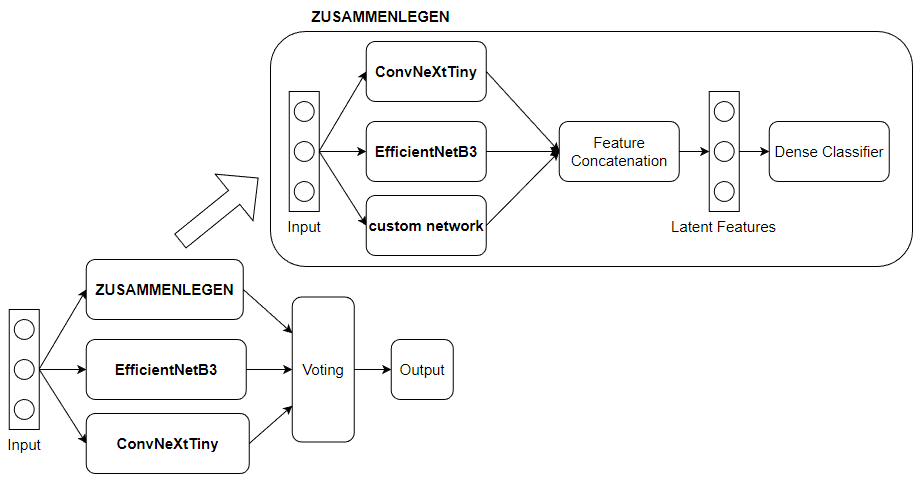

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

We import and define the preprocessing function we will need

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as pre_effnet
from tensorflow.keras.applications.convnext import preprocess_input as pre_convnext
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as pre_effnet2
def pre_ban(x):
    return x/255

In [ ]:
dataset = 'dataset'
dataSplitted_dir = 'datasetSplitted' # where to put the splitted dataset

### Data Splitting
Here we split the dataset in training and validation and we perform oversampling on train to have the same number of images in each class.

The split is:
- 90% train
- 10% validation
The reason is that the dataset was quite small so we wanted to keep as many train samples as possible

In [ ]:
import splitfolders
import shutil
splitfolders.ratio(dataset, output=dataSplitted_dir+'/tmp', seed=42, ratio=(0.9, 0.1), group_prefix=None)
splitfolders.fixed(dataSplitted_dir+'/tmp/train', output=dataSplitted_dir, seed=0x911, fixed=0, group_prefix=None, move=False, oversample=True)
shutil.rmtree(dataSplitted_dir+'/val')
shutil.move(dataSplitted_dir+'/tmp/val', dataSplitted_dir+'/val')
shutil.rmtree(dataSplitted_dir+'/tmp')

### Models Parameters
Here we define all the parameters we need to train our models. Note that we used smaller learning rates for fine tuning to avoid immediately messing up the original Imagenet weights

In [ ]:
# Training parameters
input_shape = (96, 96, 3)
batch_size = 64


# EfficientNetB3
EFFNET_params={
    "name": "effnet",
    "epochs" : 200,
    "ES_patience" : 30,
    "LR_patience" : 25,
    "LR_factor" : 0.5,
    "checkpoint_period" : 5,
    "LR" : 0.0001,
    "preprocess" : pre_effnet
}

# ConvNextTiny
CNT_params={
    "name": "convnext",
    "epochs" : 200,
    "ES_patience" : 30,
    "LR_patience" : 15,
    "LR_factor" : 0.5,
    "checkpoint_period" : 5,
    "LR" : 0.0001,
    "preprocess" : pre_convnext
}

# BetterAlexNet (custom)
BAN_params={
    "name": "ban_custom",
    "epochs" : 200,
    "ES_patience" : 20,
    "LR_patience" : 10,
    "LR_factor" : 0.5,
    "checkpoint_period" : 5,
    "LR" : 0.001,
    "preprocess" : pre_ban
}

# Zusammenlegen
ZUS_params={
    "name": "zusammenlegen",
    "epochs" : 200,
    "ES_patience" : 10,
    "LR_patience" : 5,
    "LR_factor" : 0.5,
    "checkpoint_period" : 5,
    "LR" : 0.0005,
    "preprocess" : None
}

# EfficientNetV2B3
EFFNET2_params={
    "name": "effnet2",
    "epochs" : 200,
    "ES_patience" : 30,
    "LR_patience" : 25,
    "LR_factor" : 0.5,
    "checkpoint_period" : 5,
    "LR" : 0.0001,
    "preprocess" : pre_effnet2
}


In [ ]:
seed = 0x911

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Dataset folders 
train_dir = os.path.join(dataSplitted_dir, 'train')
val_dir = os.path.join(dataSplitted_dir, 'val')

### ImgDataGenerator with augmentation

We used ImageDataGenerator to load the images for training and validation. We used a small augmentation because with a larger one models seems to not be able to train properly.
Note that **we didn't put the preprocessing function here because we will use these ImageDataGenerator for all the models**.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerators for train and val sets
train_data_gen = ImageDataGenerator(rotation_range=5,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect')

valid_data_gen = ImageDataGenerator()


train_gen = train_data_gen.flow_from_directory(directory=train_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=val_dir,
                                               target_size=(96, 96),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

This is a custom callback to load the best weight of the model (stored using checkpoints) before reducing the learning rate during training.

In [ ]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.platform import tf_logging as logging

class ReduceLRBacktrack(ReduceLROnPlateau):
    def __init__(self, best_path, initLr=0.001, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path
        self.mioLr = initLr

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best):
            if not self.in_cooldown():
                if self.wait+1 >= self.patience:
                    print("Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path) # load best weights
                    tfk.backend.set_value(self.model.optimizer.lr, self.mioLr)
                    self.mioLr = self.mioLr/2
        super().on_epoch_end(epoch, logs) # reduce LR

## "Simple" Models

Here we define the functions to create the models that will go into the ensemble. Note that we **put here the preprocessing functions as layers**.

In [ ]:
# Build the networks
def build_EFFNET(params):
	supernet = tf.keras.applications.EfficientNetB3(
		weights='imagenet',
		input_shape=input_shape,
		include_top=False
	)

	inputs = tfk.Input(shape=input_shape, name='input_effnet')
	x = tfk.layers.Lambda(params["preprocess"], name="preprocess_effnet")(inputs)
	x = supernet(x)
	x = tfkl.Flatten(name='flattening_effnet')(x)
	outputs = tfkl.Dense(8, activation='softmax', name='output_effnet')(x)

	model = tfk.Model(inputs=inputs, outputs=outputs, name=params["name"])

	model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=params["LR"]), metrics='accuracy')

	return model

def build_CONVNEXT(params):
	supernet = tfk.applications.ConvNeXtTiny(
		weights='imagenet',
		input_shape=input_shape,
		include_top=False,
	)

	supernet.trainable = True

	inputs = tfk.Input(shape=input_shape, name='input_convnext')
	x = tfk.layers.Lambda(params["preprocess"], name="preprocess_convnext")(inputs)
	x = supernet(x)
	x = tfkl.Flatten(name='flattening_convenxt')(x)
	x = tfkl.Dropout(0.2, seed=seed, name='dropout1_convnext')(x)
	x = tfkl.Dense(512, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed), name='dense_convnext')(x)
	x = tfkl.Dropout(0.1, seed=seed, name='dropout2_convnext')(x)
	outputs = tfkl.Dense(8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_convnext')(x)

	model = tfk.Model(inputs=inputs, outputs=outputs, name=params["name"])
	model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=params["LR"]), metrics='accuracy')
	return model

def build_BetterAlexNet(params):
	input_layer = tfkl.Input(shape=input_shape, name='input')
	l = tfk.layers.Lambda(params["preprocess"], name="preprocess_ban")(input_layer)
	
	filters = 32
	i = 0
	j = 0
	for i in range(4):
		l = tfkl.Conv2D(
                name=str(i)+'conv_first_ban',
                filters=filters*(2**i),
                kernel_size=(3, 3),
                strides = (1, 1),
                padding = 'same',
                activation = 'relu',
                kernel_initializer = tfk.initializers.GlorotUniform(seed)
            )(l)

		for j in range(2):
			l2 = tfkl.Conv2D(
                name=str(i)+'conv'+str(j)+'_ban',
                filters=filters*(2**i),
                kernel_size=(3, 3),
                strides = (1, 1),
                padding = 'same',
                activation = 'relu',
                kernel_initializer = tfk.initializers.GlorotUniform(seed)
            )(l)
            
			l = tfkl.Add(name=str(i)+'add'+str(j)+'_ban')([l2, l])
			l = tfkl.BatchNormalization(name=str(i)+'bnorm'+str(j)+'_ban')(l)

		l = tfkl.MaxPooling2D(
            name=str(i)+'pool_ban',
            pool_size = (2, 2)
        )(l)

	globalPooling_layer = tfkl.GlobalAveragePooling2D(name='gap_ban')(l)
	classifier_layer = tfkl.Dropout(0.1, name='dropout_ban', seed=seed)(globalPooling_layer)
	output_layer = tfkl.Dense(name='output_ban', units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed))(classifier_layer)

	model = tfk.Model(inputs=input_layer, outputs=output_layer, name=params["name"])
	model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=params["LR"]), metrics='accuracy')
	return model

def build_EFFNET2(params):
	supernet = tf.keras.applications.EfficientNetV2B3(
		weights='imagenet',
		input_shape=input_shape,
		include_top=False,
		pooling='avg'
	)

	inputs = tfk.Input(shape=input_shape, name='input_effnet2')
	x = tfk.layers.Lambda(params["preprocess"], name="preprocess_effnet2")(inputs)
	x = supernet(x)
	x = tfkl.Dropout(0.1, name='dropout_effnet2')(x)
	outputs = tfkl.Dense(8, activation='softmax', name='output_effnet2')(x)

	model = tfk.Model(inputs=inputs, outputs=outputs, name=params["name"])

	model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=params["LR"]), metrics='accuracy')

	return model

In [ ]:
# Prepare the models

modelEff = build_EFFNET(EFFNET_params)
modelConv = build_CONVNEXT(CNT_params)
modelAlex = build_BetterAlexNet(BAN_params)
modelEff2 = build_EFFNET2(EFFNET2_params)

models_list = [(modelEff, EFFNET_params), (modelConv, CNT_params), (modelAlex, BAN_params), (modelEff2, EFFNET2_params)]

Here we train our models.
(We trained each of them in a single step. For the fine tuning ones we tried also to fix the downloaded weights and train only the classifier and only after that train all the network. With this second option they seems to perform slightly worse)

In [ ]:
for model, params in models_list:
    tfk.backend.set_value(model.optimizer.learning_rate, params["LR"])
    model.fit(
        x = train_gen,
        epochs = params["epochs"],
        validation_data = valid_gen,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=params["ES_patience"], restore_best_weights=True),
            tfk.callbacks.ModelCheckpoint(params["name"]+'/checkpoint', save_freq='epoch', period=params["checkpoint_period"], save_weights_only=True, save_best_only=True), # save best weights
            ReduceLRBacktrack(params["name"]+'/checkpoint', initLr=params["LR"], monitor='val_loss', mode='min', patience=params["LR_patience"], factor=params["LR_factor"], min_lr=1e-10) # load best weights from checkpoint and reduce the LR
        ]
    )

## Zusammenlegen
In this section we define a model that concatenates the output of the convolutional parts of ConvNextTiny, EfficientnetB3 and our custom model trained beforehand (so combining their features) and then perform the classification with some dense layers.

The convolutional parts are fixed (pre-trained). In this ensembling step only the classifier at the top will be trained.



This is a utility function to reconnect the layers of our custom model after that we will remove the input and the classifier

In [ ]:
# Utils for Zusammenlegen model build
def remove_classifier_BAN(prova2, input):
		l = input
		cl = 2
		for i in range(4):
			l = prova2.layers[cl](l)
			cl+=1

			for j in range(2):
				l2 = prova2.layers[cl](l)
				cl+=1
				l = prova2.layers[cl]([l2, l])
				cl+=1
				l = prova2.layers[cl](l)
				cl+=1

			l = prova2.layers[cl](l)
			cl+=1
			
		l = prova2.layers[cl](l)
		
		return l

def pre_p2(x):
    return x/255

Build and train the so called Zusammenlegen model

In [ ]:
# Build the Zusammenlegen model

# Make all the models non trainable
for _model, _ in models_list:
    _model.trainable = False

input_layer = tfk.layers.Input(shape=input_shape, name="input_layer")

# Rebuild the networks
gap_Alex = remove_classifier_BAN(modelAlex, input_layer)

layersc=[]
layersc.append(input_layer)
for layer in modelConv.layers[1:]:
    layersc.append(layer(layersc[-1]))

layerse=[]
layerse.append(input_layer)
for layer in modelEff.layers[1:]:
    layerse.append(layer(layerse[-1]))

    
# We chose to add a new layer to the EfficientNet network in order to have a number of parameters that could match the other two networks
dense_EFF = tfkl.Dense(
    128, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed), name='dense_posteffnet')(layerse[3])


# Concatenate the network outputs and add a softmax classifier
concatenate_layer = tfkl.Concatenate(name='concat')([dense_EFF, layersc[4], gap_Alex])
outputs = tfkl.Dense(
    8, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed), name='output')(concatenate_layer)

In [ ]:
# Compile the model
zusammenlegen = tfk.Model(inputs=input_layer, outputs=outputs, name=ZUS_params["name"])
zusammenlegen.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(ZUS_params["LR"]), metrics='accuracy')

In [ ]:
# Train the model

params = ZUS_params
tfk.backend.set_value(zusammenlegen.optimizer.learning_rate, params["LR"])
zusammenlegen.fit(
    x = train_gen,
    epochs = params["epochs"],
    validation_data = valid_gen,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=params["ES_patience"], restore_best_weights=True),
        tfk.callbacks.ModelCheckpoint(ZUS_params["name"]+'/checkpoint', save_freq='epoch', period=params["checkpoint_period"], save_weights_only=True, save_best_only=True), # save best weights
        ReduceLRBacktrack(ZUS_params["name"]+'/checkpoint', initLr=params["LR"], monitor='val_loss', mode='min', patience=params["LR_patience"], factor=params["LR_factor"], min_lr=1e-10) # load best weights from checkpoint and reduce the LR
    ]
)

## Układ Warszawski (The final model)
Here we define the class used to perform the majiority voting between *ConvNextTiny*, *EfficientNetV2B3* and *Zusammenlegen*.

To each one of the three models we:
- submit the same images multiple times with different rotation
- sum the output vectors
- perform the argmax to get the prediction

Then for each images we return the most voted prediction between the three.

(**NOTE**: that the class we uploaded on CodaLab is slightly different. Not only because we needed to load the models from the memory but also because for some bug or incompatibility of the version of TensorFlow we couldn't load some models so we rebuilt them and then we loaded the weights)

In [ ]:
from scipy.ndimage import rotate

class UkladWarszawski:
	def __init__(self, model1, model2, model3):
		self.model1 = model1
		self.model2 = model2
		self.model3 = model3
		

	def predict(self, X):

		Y = tf.identity(X)
		Z = tf.identity(X)

		outf = []

		# First model prediction
		images_rot = []
		images_rot.append(X)
		for i in range(3):
			images_rot.append(rotate(X, axes=(1, 2), angle=1+i, reshape=False, mode='reflect'))
		for i in range(3):
			images_rot.append(
			rotate(X, axes=(1, 2), angle=360-1-i, reshape=False, mode='reflect'))

		prediction = []
		for images in images_rot:
			prediction.append(self.model1.predict(images))

		out = tf.zeros(prediction[0].shape)
		for p in prediction:
			out = tf.add(out, p)
		outf.append(tf.argmax(out, axis=-1))

		# Second model prediction
		images_rot = []
		images_rot.append(Y)
		for i in range(5):
			images_rot.append(rotate(Y, axes=(1, 2), angle=1+i, reshape=False, mode='reflect'))
		for i in range(5):
			images_rot.append(rotate(Y, axes=(1, 2), angle=360-1-i, reshape=False, mode='reflect'))

		prediction = []
		for images in images_rot:
			prediction.append(self.model2.predict(images))

		out = tf.zeros(prediction[0].shape)
		for p in prediction:
			out = tf.add(out, p)
		outf.append(tf.argmax(out, axis=-1))

		# Third model prediction
		images_rot = []
		images_rot.append(Z)
		for i in range(3):
			images_rot.append(rotate(Z, axes=(1, 2), angle=1+i, reshape=False, mode='reflect'))
		for i in range(3):
			images_rot.append(rotate(Z, axes=(1, 2), angle=360-1-i, reshape=False, mode='reflect'))

		prediction = []
		for images in images_rot:
			prediction.append(self.model3.predict(images))

		out = tf.zeros(prediction[0].shape)
		for p in prediction:
			out = tf.add(out, p)
		outf.append(tf.argmax(out, axis=-1))

		# Postprocessing

		a = np.array(outf[0])
		b = np.array(outf[1])
		c = np.array(outf[2])

		prediction = []
		for i in range(len(a)):
			if (a[i] == b[i] or a[i] == c[i]):
				prediction.append(a[i])
			elif (b[i] == c[i]):
					prediction.append(c[i])
			elif (a[i] != b[i] != c[i]):
					prediction.append(a[i])

		numpy_pred = np.array(prediction)
		tensor_pred = tf.convert_to_tensor(numpy_pred)
		return tensor_pred

In [ ]:
ukladWarszawski = UkladWarszawski(modelConv, modelEff2, zusammenlegen)

Plot the three models used for voting in układWarszawski

In [ ]:
tfk.utils.plot_model(modelConv, expand_nested=True,  show_shapes=True, show_layer_names=True)

In [ ]:
tfk.utils.plot_model(modelEff2, expand_nested=True,  show_shapes=True, show_layer_names=True)

In [ ]:
tfk.utils.plot_model(zusammenlegen, expand_nested=True,  show_shapes=True, show_layer_names=True)